In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from joblib import dump
from joblib import load
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import pickle


In [2]:
df = pd.read_csv(r'C:\Users\mj\Desktop\ML-\sales_train.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(['item_id','price'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        109600 non-null  datetime64[ns]
 1   item_count  109600 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [3]:
#converting the date into a monthe period , then sum the number of item sold in each month :
df['date'] = df['date'].dt.to_period("M")
monthly_sales = df.groupby('date').sum().reset_index()
#convert the resulting t column to time stamb
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,item_count
0,2019-01-01,12593.0
1,2019-02-01,13184.0
2,2019-03-01,17454.0
3,2019-04-01,19034.0
4,2019-05-01,23071.0
5,2019-06-01,23154.0
6,2019-07-01,23121.0
7,2019-08-01,22032.0
8,2019-09-01,17999.0
9,2019-10-01,16114.0


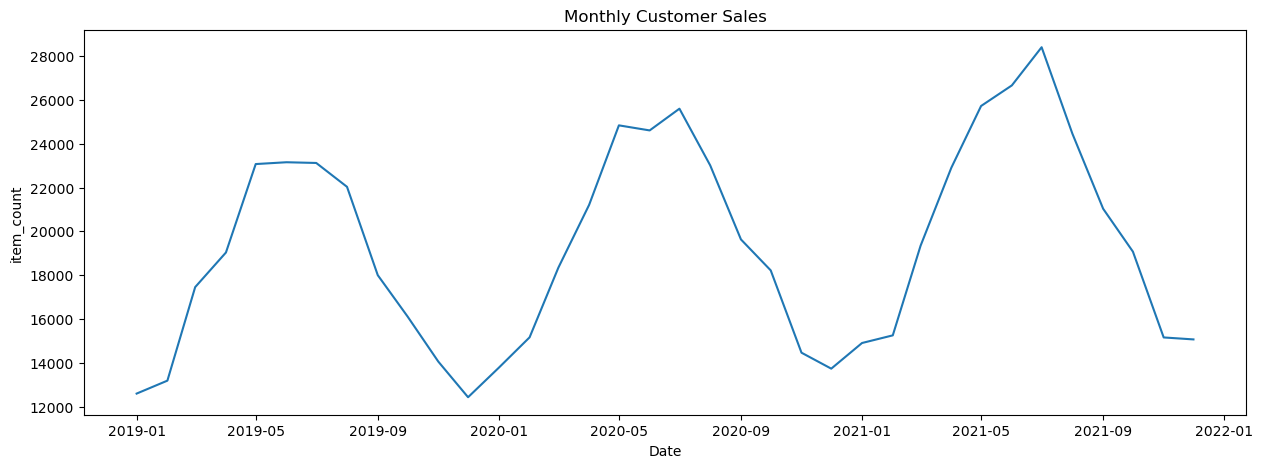

In [4]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['item_count'])
plt.xlabel('Date')
plt.ylabel('item_count')
plt.title('Monthly Customer Sales')
plt.show()

In [5]:
#data shows an increasing rate over time (Trend: If the data has a noticeable increasing or decreasing trend,)
#so i call the difference on the item count(sales) culomns to make the sales data stationery
monthly_sales['sales_diff'] = monthly_sales['item_count'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,item_count,sales_diff
1,2019-02-01,13184.0,591.0
2,2019-03-01,17454.0,4270.0
3,2019-04-01,19034.0,1580.0
4,2019-05-01,23071.0,4037.0
5,2019-06-01,23154.0,83.0
6,2019-07-01,23121.0,-33.0
7,2019-08-01,22032.0,-1089.0
8,2019-09-01,17999.0,-4033.0
9,2019-10-01,16114.0,-1885.0
10,2019-11-01,14054.0,-2060.0


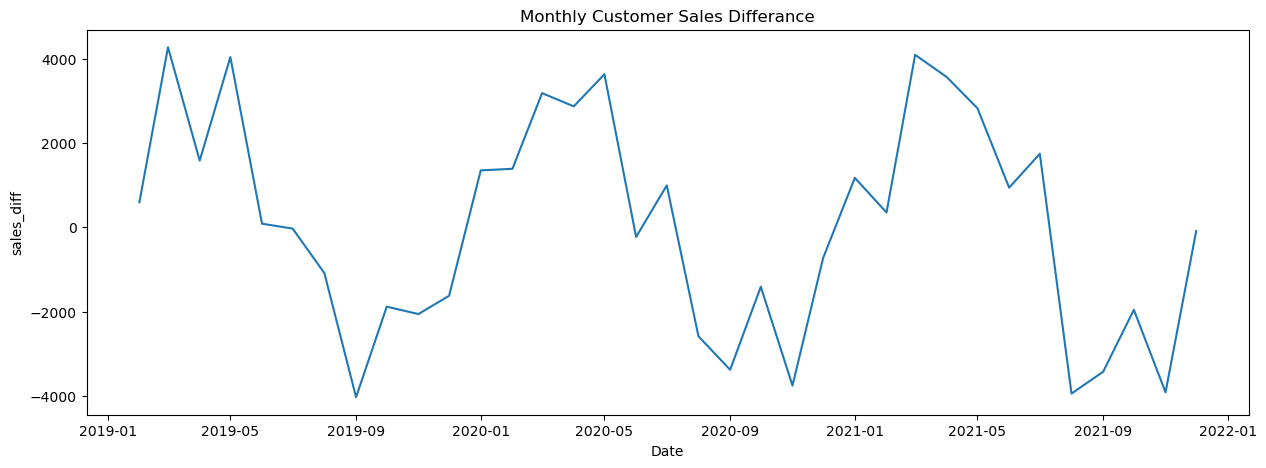

In [6]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('sales_diff')
plt.title('Monthly Customer Sales Differance')
plt.show()

In [7]:
#Dropping off item_count and date (non stationary data) to create supervised data
supervised_data = monthly_sales.drop(['date','item_count'],axis=1)
supervised_data.head(10)

,sales_diff
1,591.0
2,4270.0
3,1580.0
4,4037.0
5,83.0
6,-33.0
7,-1089.0
8,-4033.0
9,-1885.0
10,-2060.0


In [8]:
for i in range(1, 7):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6
0,-1089.0,-33.0,83.0,4037.0,1580.0,4270.0,591.0
1,-4033.0,-1089.0,-33.0,83.0,4037.0,1580.0,4270.0
2,-1885.0,-4033.0,-1089.0,-33.0,83.0,4037.0,1580.0
3,-2060.0,-1885.0,-4033.0,-1089.0,-33.0,83.0,4037.0
4,-1627.0,-2060.0,-1885.0,-4033.0,-1089.0,-33.0,83.0
5,1348.0,-1627.0,-2060.0,-1885.0,-4033.0,-1089.0,-33.0
6,1386.0,1348.0,-1627.0,-2060.0,-1885.0,-4033.0,-1089.0
7,3181.0,1386.0,1348.0,-1627.0,-2060.0,-1885.0,-4033.0
8,2867.0,3181.0,1386.0,1348.0,-1627.0,-2060.0,-1885.0
9,3629.0,2867.0,3181.0,1386.0,1348.0,-1627.0,-2060.0


In [9]:
#previous 12 month
Train_data = supervised_data[:-6]
#comming 12 month
Test_data = supervised_data[-6:]

#printing the shape of train_test to make sure our dataset is appropriate for our logic
print('Train data shape : ',Train_data.shape)
print('Test data shape : ',Test_data.shape)


Train data shape :  (23, 7)
Test data shape :  (6, 7)


In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(Train_data)
Train_data = scaler.transform(Train_data)
Test_data = scaler.transform(Test_data)


In [11]:
#in the supervised data ; the first column is the output 
x_train , y_train = Train_data[:,1:] , Train_data[:,0:1]
x_test , y_test = Test_data[:,1:] , Test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train shape : ',x_train.shape)
print('y_train shape : ',y_train.shape)
print('x_test shape : ',x_test.shape)
print('y_test shape : ',y_test.shape)

x_train shape :  (23, 6)
y_train shape :  (23,)
x_test shape :  (6, 6)
y_test shape :  (6,)


In [12]:
sales_dates = monthly_sales['date'][-6:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [13]:
actual_sales = monthly_sales['item_count'][-7:].tolist()
print(actual_sales)

[26662.0, 28405.0, 24458.0, 21031.0, 19072.0, 15156.0, 15066.0]


In [14]:
# LinearRegression model + the pridected output
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_predict = lr_model.predict(x_test)

In [15]:
#transforme the predicted values to the origenal scale 
lr_predict = lr_predict.reshape(-1,1)
#this is a matrix- contain the iput features of the test data and the predicted output
lr_pre_test_set = np.concatenate([lr_predict,x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [16]:
#calculate the predicted sale values and append it to a result_list
result_list = []
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + actual_sales[index])
lr_pre_series = pd.Series(result_list,name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)
print(predict_df)

        date  Linear Prediction
0 2021-07-01       28411.970304
1 2021-08-01       24930.575978
2 2021-09-01       22504.492000
3 2021-10-01       19493.165565
4 2021-11-01       13532.972519
5 2021-12-01       13296.377703


In [17]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['item_count'][-6:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['item_count'][-6:])
lr_r2 = r2_score(predict_df['Linear Prediction'],monthly_sales['item_count'][-6:])
print('Linear Regression MSE = ', lr_mse)
print('Linear Regression MAE = ', lr_mae)
print('Linear Regression R2 = ', lr_r2)

Linear Regression MSE =  1178.821235060449
Linear Regression MAE =  961.1422707800048
Linear Regression R2 =  0.9555505927087595


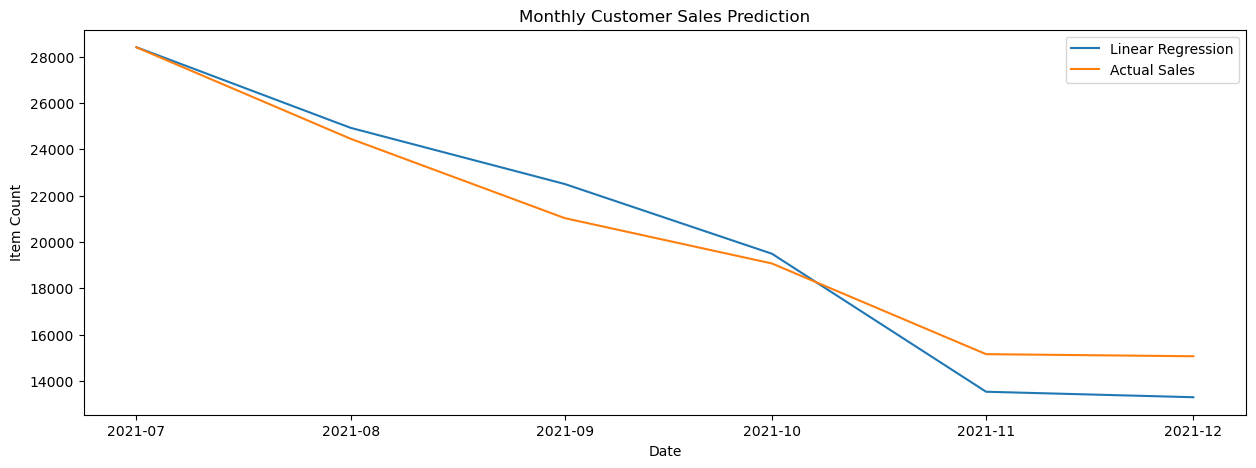

        Date  Predicted Sales
0 2021-07-01     28411.970304
1 2021-08-01     24930.575978
2 2021-09-01     22504.492000
3 2021-10-01     19493.165565
4 2021-11-01     13532.972519
5 2021-12-01     13296.377703


In [18]:
# Plotting the predicted values
plt.figure(figsize=(15, 5))
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Regression')
plt.plot(monthly_sales['date'][-6:], monthly_sales['item_count'][-6:], label='Actual Sales')
plt.xlabel('Date')
plt.ylabel('Item Count')
plt.title('Monthly Customer Sales Prediction')
plt.legend()
plt.show()

# Printing the predicted values in a table format
prediction_table = predict_df[['date', 'Linear Prediction']]
prediction_table.columns = ['Date', 'Predicted Sales']
print(prediction_table)


In [19]:
#saving the model 
filename = "sales_forecasting_model.pkl"
pickle.dump(lr_model, open(filename, "wb"))